# Init

In [1]:
from pyfiles import (
    complex as cplx,
    grid as grid,
    utils as utils,
    examples as ex,
    input as inp,
    plot as ourplot
)
from pyfiles.examples import CameraOpt

# so we don't have to reboot kernel every time we modify classes.py
%load_ext autoreload
%autoreload 2

import numpy as np
from typing import *
import matplotlib.pyplot as plt
%matplotlib inline
import mars

def export_obj(ex: ex.Example, complex: cplx.complex, faces: List[np.ndarray]):
    out_name = ex.filename.replace('input', 'output')
    name = out_name.split('/')[-1]
    name = name.split('.')[0]
    filename = f'output/{name}-GB{ex.grid_buffer}-GS{ex.grid_size}-MA{ex.medial_axis}'
    if ex.prune_eps is not None:
        filename += f'-peps{ex.prune_eps}'
    filename += '.obj'

    with open(filename, 'w') as f:
        vi = 1
        f.write(f'o {name}\n')
        for triangle in complex.trilist:
            a = triangle.coords[0]
            b = triangle.coords[1]
            c = triangle.coords[2]
            f.write(f'v {a[0]} {a[1]} {a[2]}\n')
            f.write(f'v {b[0]} {b[1]} {b[2]}\n')
            f.write(f'v {c[0]} {c[1]} {c[2]}\n')
            f.write(f'f {vi + 0} {vi + 1} {vi + 2}\n')
            vi += 3

        f.write(f'o {name}-MA{ex.medial_axis}\n')
        for [a, b, c, d] in faces:
            f.write(f'v {a[0]} {a[1]} {a[2]}\n')
            f.write(f'v {b[0]} {b[1]} {b[2]}\n')
            f.write(f'v {c[0]} {c[1]} {c[2]}\n')
            f.write(f'v {d[0]} {d[1]} {d[2]}\n')
            f.write(f'f {vi + 0} {vi + 1} {vi + 2} {vi + 3}\n')
            vi += 4
    print(f'Wrote {filename}')


# input

In [2]:
example = ex.ellipse2d_extrude_2

our_complex = inp.read_obj(example.filename)
gridd = grid.Grid3.from_complex(our_complex, example.grid_size, buffer=example.grid_buffer)

rs_complex = mars.read_from_obj(example.filename)

list_of_swaps = []
'''A list of swaps of the form `(old-cell, new-cell, [swaps])`'''

rs_states = {}
'''States for each point.  Used to live in the python Grid3'''

n_edges = gridd.number_of_grid_edges()
visit_count = 0
def visit(new_cell: Tuple[int,int,int], old_cell: Tuple[int,int,int]):
  global visit_count
  visit_count += 1
  perf = visit_count / n_edges * 100
  print(f'visiting {visit_count}/{n_edges} ({perf:.1f}%)\r', end='')
  if old_cell is None:
    center_point = gridd.coordinate(new_cell)
    with utils.Timed('rs reduce'):
      rs_states[new_cell] = mars.reduce_from_scratch(rs_complex, list(center_point))
  else:
    new_point = gridd.coordinate(new_cell)
    with utils.Timed('rs reduce_vine'):
      rs_old_state = rs_states[old_cell]
      (rs_new_state, swaps) = mars.vineyards_123(rs_complex, rs_old_state, list(new_point))
      list_of_swaps.append((old_cell, new_cell, swaps))
      rs_states[new_cell] = rs_new_state

with utils.Timed('flood_fill_visit'):
  gridd.flood_fill_visit(gridd.center_index(), visit)
utils.Timed.report()

|======== Timed report ========
| rs reduce       :     704.72ms  (704.725ms per; #1)
| rs reduce_vine  :     976.14ms  ( 0.353ms per; #2768)
| flood_fill_visit:    1697.45ms  (1697.447ms per; #1)
|==============================


# chop chop

Found 1247 faces
Wrote output/ellipse2d-extrude-2-GB0.1-GS0.1-MA0.obj


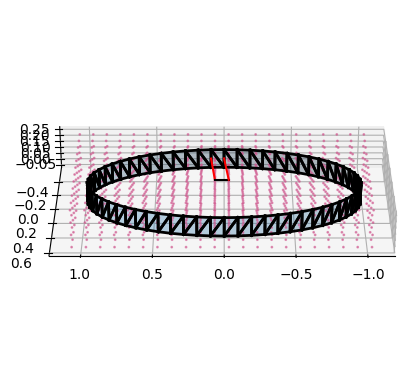

In [3]:
# CONTROL PARAMETERS
medaxdim = 1 # can say example.medial_axis when set

# euclidean prune: all dims
euclid_prune = False
prune_dist = 0.2


# coboundary: dim 0,2
cofaceprune = False

# faceprune: dim 1,2
faceprune = False

# persistence prune: dim 1
persprune = True
persistence_threshold = 0.01

###########################################

faces = []
swap_coordinate_pairs = []
for (old_cell, new_cell, swaps) in list_of_swaps:
  state_old = rs_states[old_cell]
  state_new = rs_states[new_cell]
  swaps = swaps.pyclone()

  # PRUNING
  # coboundary: mainly for dim 0,2
  if cofaceprune:
    swaps.prune_coboundary(rs_complex)
  if faceprune:
    swaps.prune_common_face(rs_complex)

  # persistence: mainly for dim 1
  if persprune:
    swaps.prune_persistence(rs_complex, state_old, state_new, persistence_threshold)

  # euclidean prune: for all dims
  # NOTE: dist prune is NOT grid size based, it is absolute dist
  # if example.prune_dist is not None:
  #   swaps.prune_euclidian(rs_complex, example.prune_dist**2)
  if euclid_prune:
    swaps.prune_euclidian(rs_complex, prune_dist**2)
  # END PRUNING

  # CHOOSE MEDIAL AXIS HERE (`example.medial_axis`):
  swaps = list(filter(lambda t: t.dim == medaxdim, swaps.v))

  if 0 < len(swaps):
    faces.append(gridd.dual_face(old_cell, new_cell))
    s = swaps[0]
    swap_coordinate_pairs.append((
      gridd.coordinate(old_cell),
      gridd.coordinate(new_cell),
      rs_complex.simplices_per_dim[s.dim][s.i].center_point(rs_complex),
      rs_complex.simplices_per_dim[s.dim][s.j].center_point(rs_complex),
    ))

i = 8

print(f'Found {len(faces)} faces')
export_obj(example, our_complex, faces)
plt, ax = ourplot.plot_vineyard_results(
  our_complex,
  gridd,
  faces[i:i+1],
  CameraOpt(azim=90, elev=30),
  # only_edges=True,
  # complex_vertices=True,
  # skip_grid=True,
  # skip_cube=True
)

for (g1,g2,s1,s2) in swap_coordinate_pairs[i:i+1]:
  ax.plot([g1[0], s1[0]], [g1[1], s1[1]], [g1[2], s1[2]], '-', color='red')
  ax.plot([g1[0], g2[0]], [g1[1], g2[1]], [g1[2], g2[2]], '-', color='black')
  ax.plot([g2[0], s2[0]], [g2[1], s2[1]], [g2[2], s2[2]], '-', color='red')
